# Final Recap Lab
---

## Using the KDDCup dataset, find the best SML model

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The KDDCup intrusion detection data stream records intrusions simulated in a military network environment. The task is to classify network traffic into **normal** (80.31% of the cases) or some kind of **intrusion** (19.69% of the cases) described by *41 features*, of which *34 numeric* and *7 nominal*. The problem of temporal dependence is particularly evident here. Inspecting the raw stream confirms that there are time periods of intrusions rather than single instances of intrusions.
The *7 nominal* attributes are:
- protocol_type
- service
- flag
- land
- logged_in
- is_host_login
- is_guest_login

**Class:** `class` | 0: normal, 1: intrusion
 
**Samples:** 494021


In [24]:
df = pd.read_csv("https://raw.githubusercontent.com/emanueledellavalle/streaming-data-analytics/main/codes/SML/datasets/KDDCup.csv").iloc[:12500,:]
features = df.columns[:-1]
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

## Plot data distribution
---
Encode the protocol_type, service and flag attributes and apply the **PCA**

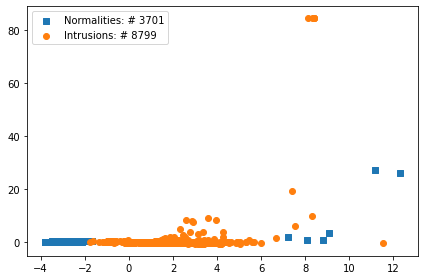

In [25]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

encoder = OrdinalEncoder()
encDf = df.copy()
encDf[["protocol_type","service","flag"]] = encoder.fit_transform(encDf[["protocol_type","service","flag"]])


features = encDf.drop(["class"],axis=1)
label = encDf["class"]

scaled_features = StandardScaler().fit_transform(features)
num_components = 2
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(scaled_features)
pca_data.shape

pc_df = pd.DataFrame(data = pca_data,columns = ["pc1", "pc2"])
pc_df["class"] = label

normalities = pc_df[pc_df["class"] == 0]
intrusions = pc_df[pc_df["class"] == 1]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(x=normalities["pc1"], y=normalities["pc2"], marker="s", label='Normalities: # ' + str(normalities.shape[0]))
ax1.scatter(x=intrusions["pc1"], y=intrusions["pc2"], marker="o", label='Intrusions: # ' + str(intrusions.shape[0]))
plt.legend(loc='upper left');
fig.tight_layout()
plt.show()

## Find the best SML model!
---
### Hint
Since the stream is imbalances, the Accuracy is not a reliable metric. Try using [BalancedAccuracy](https://riverml.xyz/latest/api/metrics/BalancedAccuracy/) and [GeometricMean](https://riverml.xyz/latest/api/metrics/GeometricMean/) instead. To combine them, use [Metrics](https://riverml.xyz/latest/api/metrics/Metrics/)

In [26]:
from river.stream import iter_pandas
from river.evaluate import progressive_val_score
from river.metrics.base import Metrics
from river.metrics import Accuracy,BalancedAccuracy,GeometricMean,CohenKappa
from river import compose

from river.naive_bayes import GaussianNB
from river.tree import HoeffdingAdaptiveTreeClassifier
from river.ensemble import AdaptiveRandomForestClassifier
from river.ensemble import ADWINBaggingClassifier
from river.tree import HoeffdingTreeClassifier
from river.ensemble import LeveragingBaggingClassifier
from river.ensemble import SRPClassifier
from river.drift import ADWIN

In [27]:
features = df.columns[:-1]
X_train = df[features]
y_train = df['class']

X_train.drop('protocol_type', inplace=True, axis=1)
X_train.drop('service', inplace=True, axis=1)
X_train.drop('flag', inplace=True, axis=1)


X_train.head()

/Users/ajeje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,181,5450,0,0,0,0,0,1,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,239,486,0,0,0,0,0,1,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,235,1337,0,0,0,0,0,1,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,219,1337,0,0,0,0,0,1,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,217,2032,0,0,0,0,0,1,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


### Naive Bayes

In [28]:
model1 = GaussianNB()

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model1,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[5,000] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[7,500] Accuracy: 99.95%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[10,000] Accuracy: 77.87%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[12,500] Accuracy: 70.39%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%


### HAT

In [29]:
model2 = HoeffdingAdaptiveTreeClassifier()

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model2,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[5,000] Accuracy: 99.86%, BalancedAccuracy: 49.97%, GeometricMean: 0.00%, CohenKappa: -0.07%
[7,500] Accuracy: 99.91%, BalancedAccuracy: 49.98%, GeometricMean: 0.00%, CohenKappa: -0.05%
[10,000] Accuracy: 99.74%, BalancedAccuracy: 99.46%, GeometricMean: 99.46%, CohenKappa: 99.24%
[12,500] Accuracy: 99.48%, BalancedAccuracy: 99.45%, GeometricMean: 99.45%, CohenKappa: 98.75%


### Adaptive random forest

In [30]:
model3 = AdaptiveRandomForestClassifier(n_models = 7)

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model3,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[5,000] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[7,500] Accuracy: 99.95%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[10,000] Accuracy: 99.79%, BalancedAccuracy: 99.53%, GeometricMean: 99.52%, CohenKappa: 99.39%
[12,500] Accuracy: 99.82%, BalancedAccuracy: 99.71%, GeometricMean: 99.71%, CohenKappa: 99.58%


### ADWIN Bagging

In [32]:
model4 = ADWINBaggingClassifier(model=HoeffdingTreeClassifier(), n_models = 4)

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model4,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.92%, BalancedAccuracy: 50.00%, GeometricMean: 0.00%, CohenKappa: 0.00%
[5,000] Accuracy: 99.88%, BalancedAccuracy: 49.98%, GeometricMean: 0.00%, CohenKappa: -0.05%
[7,500] Accuracy: 99.92%, BalancedAccuracy: 49.99%, GeometricMean: 0.00%, CohenKappa: -0.04%
[10,000] Accuracy: 98.72%, BalancedAccuracy: 97.16%, GeometricMean: 97.12%, CohenKappa: 96.21%
[12,500] Accuracy: 98.97%, BalancedAccuracy: 98.29%, GeometricMean: 98.27%, CohenKappa: 97.50%


### Hoeffding Tree Classifier

In [33]:
model5 = HoeffdingTreeClassifier()

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model5,
                      metric=metrics,
                      print_every=2500))


[2,500] Accuracy: 99.88%, BalancedAccuracy: 49.98%, GeometricMean: 0.00%, CohenKappa: -0.05%
[5,000] Accuracy: 99.84%, BalancedAccuracy: 49.96%, GeometricMean: 0.00%, CohenKappa: -0.08%
[7,500] Accuracy: 99.89%, BalancedAccuracy: 49.97%, GeometricMean: 0.00%, CohenKappa: -0.05%
[10,000] Accuracy: 99.71%, BalancedAccuracy: 99.41%, GeometricMean: 99.41%, CohenKappa: 99.16%
[12,500] Accuracy: 99.39%, BalancedAccuracy: 99.37%, GeometricMean: 99.37%, CohenKappa: 98.54%


### Leveraging Bagging Classifier

In [34]:
model5 = LeveragingBaggingClassifier(model=HoeffdingTreeClassifier(), n_models = 4)

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model5,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.92%, BalancedAccuracy: 74.98%, GeometricMean: 70.70%, CohenKappa: 49.96%
[5,000] Accuracy: 99.92%, BalancedAccuracy: 62.49%, GeometricMean: 49.99%, CohenKappa: 33.30%
[7,500] Accuracy: 99.95%, BalancedAccuracy: 62.49%, GeometricMean: 50.00%, CohenKappa: 33.31%
[10,000] Accuracy: 99.60%, BalancedAccuracy: 99.11%, GeometricMean: 99.11%, CohenKappa: 98.83%
[12,500] Accuracy: 99.66%, BalancedAccuracy: 99.45%, GeometricMean: 99.45%, CohenKappa: 99.17%


### SRPC

In [36]:
model6 = SRPClassifier(model=HoeffdingTreeClassifier(),
                      n_models=4,
                      drift_detector=ADWIN(delta=0.001),
                      warning_detector=ADWIN(delta=0.01)
                      )

metrics = Metrics(metrics=[Accuracy(),BalancedAccuracy(),GeometricMean(),CohenKappa()])
stream = iter_pandas(X= X_train, y= y_train)

pred.append(progressive_val_score(dataset=stream,
                      model=model6,
                      metric=metrics,
                      print_every=2500))

[2,500] Accuracy: 99.84%, BalancedAccuracy: 74.94%, GeometricMean: 70.67%, CohenKappa: 33.26%
[5,000] Accuracy: 99.88%, BalancedAccuracy: 62.47%, GeometricMean: 49.98%, CohenKappa: 24.94%
[7,500] Accuracy: 99.92%, BalancedAccuracy: 62.48%, GeometricMean: 49.99%, CohenKappa: 24.96%
[10,000] Accuracy: 99.61%, BalancedAccuracy: 99.17%, GeometricMean: 99.16%, CohenKappa: 98.86%
[12,500] Accuracy: 99.39%, BalancedAccuracy: 99.29%, GeometricMean: 99.29%, CohenKappa: 98.54%
